In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split train into train and val
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Create loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


In [3]:
import torch
import torch.nn as nn

class ImprovedANN(nn.Module):
    def __init__(self, input_size=3*32*32, num_classes=10):
        super(ImprovedANN, self).__init__()

        hidden_sizes = [2500, 2000, 2000, 1000, 1000, 500, 500, 250, 100]  # 9 hidden layers

        layers = []
        in_size = input_size
        for i, h in enumerate(hidden_sizes):
            layers.append(nn.Linear(in_size, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1 if i >= 5 else 0.2))  # less dropout in later layers
            in_size = h

        layers.append(nn.Linear(hidden_sizes[-1], num_classes))  # Output layer

        self.classifier = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        return self.classifier(x)

In [4]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("ANN Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, val_losses = [], []
    train_accuracies = []   # List to store train accuracy per epoch

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy batch-wise
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], LR: {scheduler.get_last_lr()[0]:.6f}, "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses, train_accuracies

In [6]:
model = ImprovedANN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

Epoch [1/30], LR: 0.001000, Train Loss: 1.9755, Train Acc: 26.77%, Val Loss: 1.8460
Epoch [2/30], LR: 0.001000, Train Loss: 1.8197, Train Acc: 34.11%, Val Loss: 1.7747
Epoch [3/30], LR: 0.001000, Train Loss: 1.7384, Train Acc: 36.65%, Val Loss: 1.6852
Epoch [4/30], LR: 0.001000, Train Loss: 1.6827, Train Acc: 39.14%, Val Loss: 1.6328
Epoch [5/30], LR: 0.001000, Train Loss: 1.6505, Train Acc: 40.67%, Val Loss: 1.6058
Epoch [6/30], LR: 0.001000, Train Loss: 1.6137, Train Acc: 41.91%, Val Loss: 1.5756
Epoch [7/30], LR: 0.001000, Train Loss: 1.5925, Train Acc: 42.89%, Val Loss: 1.5467
Epoch [8/30], LR: 0.001000, Train Loss: 1.5685, Train Acc: 43.72%, Val Loss: 1.5297
Epoch [9/30], LR: 0.001000, Train Loss: 1.5499, Train Acc: 44.56%, Val Loss: 1.4917
Epoch [10/30], LR: 0.000500, Train Loss: 1.5362, Train Acc: 45.17%, Val Loss: 1.4882
Epoch [11/30], LR: 0.000500, Train Loss: 1.4758, Train Acc: 46.95%, Val Loss: 1.4325
Epoch [12/30], LR: 0.000500, Train Loss: 1.4549, Train Acc: 47.59%, Val Lo

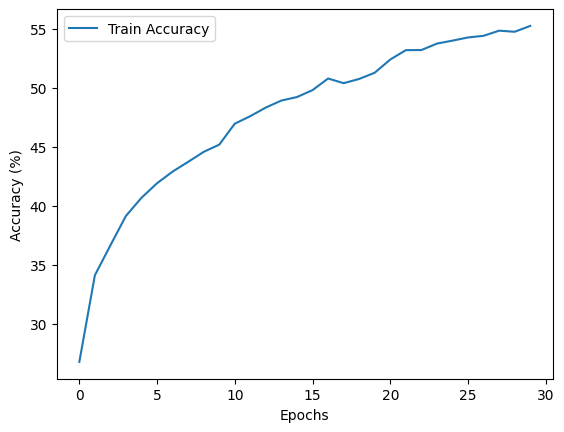

In [7]:
train_losses, val_losses, train_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler)

plt.plot(train_accuracies, label="Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [8]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("ANN Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

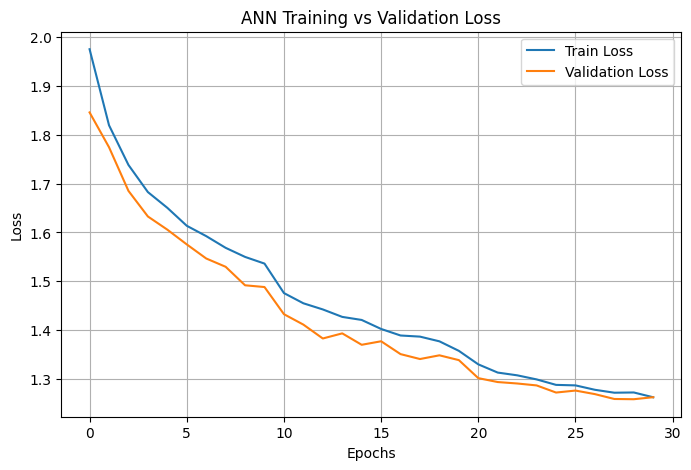

In [9]:
plot_loss(train_losses, val_losses)

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

# Make predictions and collect true/false labels
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to("cuda")
        labels = labels.to("cuda")
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

In [12]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [13]:
from sklearn.metrics import classification_report

print(classification_report(all_targets, all_preds, target_names=class_names))


              precision    recall  f1-score   support

    airplane       0.63      0.63      0.63      1000
  automobile       0.70      0.70      0.70      1000
        bird       0.45      0.42      0.44      1000
         cat       0.41      0.32      0.36      1000
        deer       0.51      0.49      0.50      1000
         dog       0.48      0.47      0.48      1000
        frog       0.57      0.69      0.63      1000
       horse       0.67      0.68      0.67      1000
        ship       0.71      0.70      0.70      1000
       truck       0.61      0.69      0.65      1000

    accuracy                           0.58     10000
   macro avg       0.58      0.58      0.58     10000
weighted avg       0.58      0.58      0.58     10000



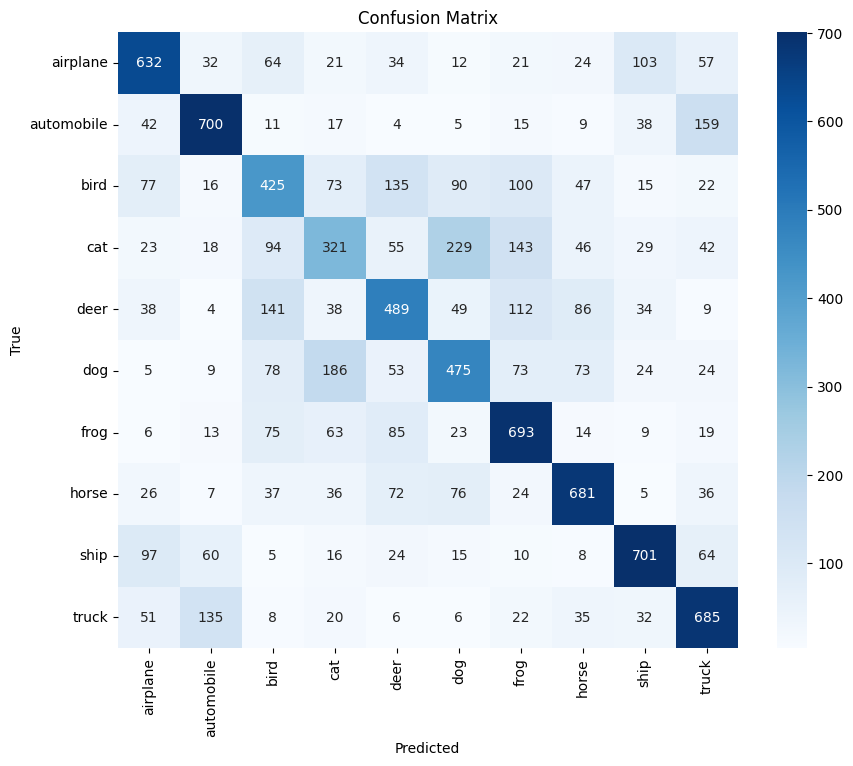

In [14]:
import seaborn as sns
cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [16]:
# Binarize labels for ROC (One-vs-All)
n_classes = 10
y_true = label_binarize(all_targets, classes=range(n_classes))

# Get prediction probabilities
y_score = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to("cuda")
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        y_score.extend(probs.cpu().numpy())

y_score = np.array(y_score)

<ipython-input-17-fecbecb85023>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', 10)


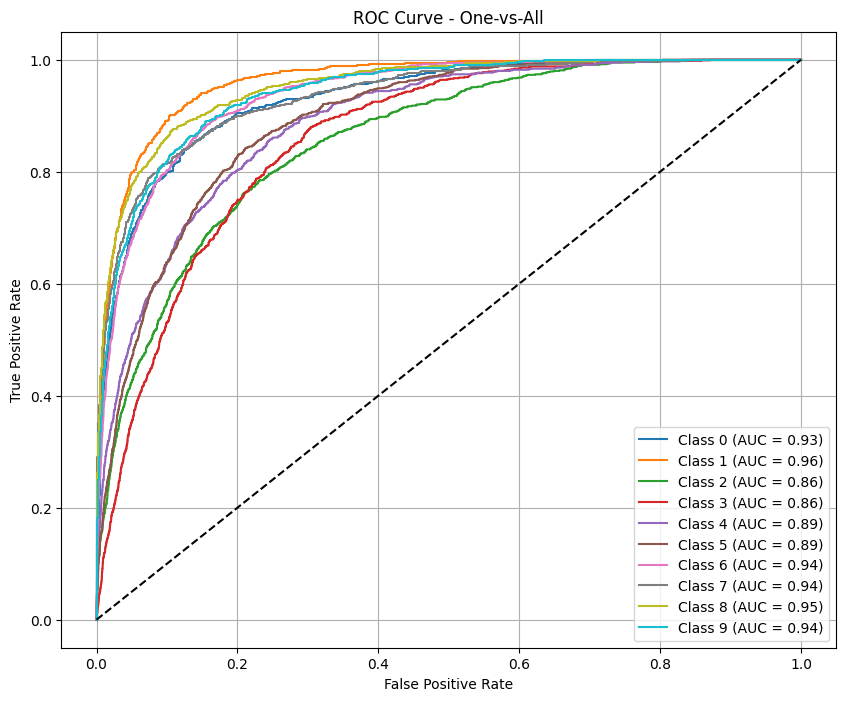

In [17]:
# Plot ROC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', 10)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})", color=colors(i))

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.title("ROC Curve - One-vs-All")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [18]:
from sklearn.metrics import roc_auc_score
macro_roc_auc = roc_auc_score(y_true, y_score, average='macro', multi_class='ovr')
print(f"Macro-average ROC AUC score: {macro_roc_auc:.4f}")

Macro-average ROC AUC score: 0.9155


In [20]:
import torch
import torch.nn.functional as F

all_probs = []
all_targets = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to("cuda")
        labels = labels.to("cuda")

        outputs = model(images)                         # raw logits
        probs = F.softmax(outputs, dim=1)               # convert to probabilities

        all_probs.append(probs.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)
all_targets = np.array(all_targets)

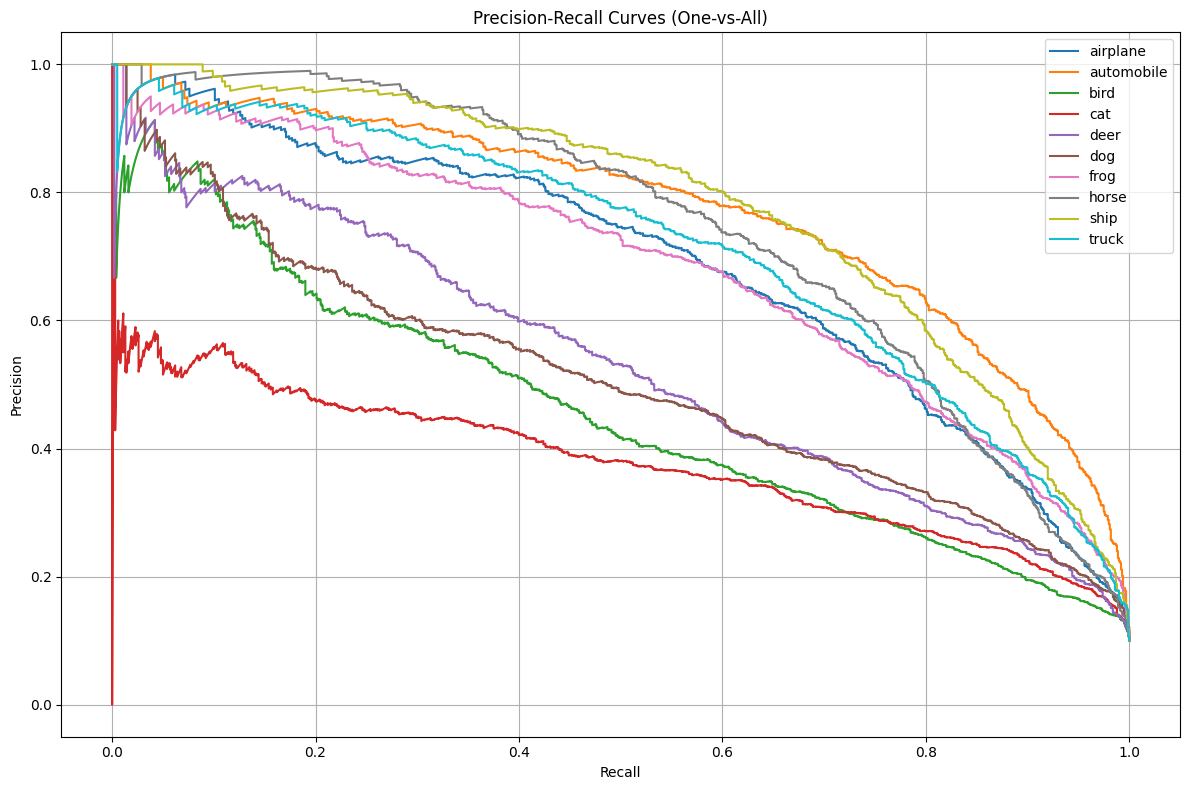

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import numpy as np

n_classes = 10
y_test_binarized = label_binarize(all_targets, classes=np.arange(n_classes))

# Plot Precision-Recall curve for each class
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], all_probs[:, i])
    plt.plot(recall, precision, label=f"{class_names[i]}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (One-vs-All)")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()